# Linguistic Harbinger of Fake News - Paper Extension

In this extension, our goal is to explore whether the linguistic cues found in the original paper are suitable for a descriptive/predictive analysis in the context of fake news recognition.

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
import nltk.data
import re
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from discourseMarkers import rule
from nltk import word_tokenize
from nltk import sentiment
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.parse.corenlp import CoreNLPParser
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from resources import lemmatizer, premise_conclusion_markers, english_dictionary, wordnet
from transformers import BertTokenizer
from sentiment_bert import SentimentBERT
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn import metrics

# Create and register a new `tqdm` instance with `pandas`
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/oraziorillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/tqd

### Step 0: the dataset

The dataset that we are using in the following analysis has been downloaded from Kaggle at this [link](https://www.kaggle.com/jruvika/fake-news-detection).
It is composed by 4009 entries of real of fake articles about different topics. Each entry specifies the source URLs of the article, its title, its body and a label that is 0 in case the news is fake and 1 otherwise.

The dataset contains some articles with empty body. We decided to discard such articles since none of the features that we try to identify is meaningful if computed by using the title only.

Note that even though the dataset contains the source URLs of the articles, they will not be used on purpose in the following analysis: our intention is to explore linguistic cues that characterize deception, not to distinguish trustworthy from untrustworty websites.

In [2]:
data_raw = pd.read_csv("data/data.csv")
data = data_raw.copy(deep = True).dropna().reset_index(drop=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3988 entries, 0 to 3987
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      3988 non-null   object
 1   Headline  3988 non-null   object
 2   Body      3988 non-null   object
 3   Label     3988 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 124.8+ KB


### Step 1: Preprocessing and Feature Extraction 

Both preprocessing and feature extraction are performed by the same function: extract_linguisic_features, which first cleans the dataset and then applies the feature extractors. 

The first cleaning is very simple, since some of the feature extractors require the sentences to be plain text. Indeed, the only operation applied to all the sentences in the dataset has been to swap fullstop and ending quotes whenever they were found in the wrong order at the end of quoted sentence. Many times we were able to recognise the pattern '.”' in the articles; however, the correct order is: '”.'. This was a problem when we tried to split an artilce in subsentences. nltk's sentence tokenizer, in fact, does not recognize the end of a sentence all the times the mentioned pattern occurs.

The features that we will try to identify for each article are the following ones:
 - number_of_sentences: number of sentences in the article, first split the article into sentences and then count them;
 - number_of_words: number of word tokens in the article (special characters, that are usually considered tokens by the nltk tokenizer, are discarded);
 - average_sentence_lenght: average lenght of the article's sentences, to compute it divide the total number of words by the number of sentences in the article;
 - average_word_lenght: average lenght of words in the article, computed by averaging the lenghts words in the article;
 - nltk_sentiment: numerical value that describes the sentiment of the article, computed using the Sentiment Intensity Analyzer by nltk;
 - nltk_sentiment: numerical value that describes the sentiment of the article, computed using the our fine-tuned BERT sentiment classifier;
 - subjectivity: numerical value that describes how much the article is subjective, computing using TextBlob;
 - number_of_premise_conclusion_markers: number of premise or conclusion markers in the article, computed by looking for specific markers taken from an handcrafted lexicon which takes ispiration form this online [resource](https://academic.csuohio.edu/polen/LC9_Help/1/11pcindicators.htm);
 - dictionary_percentage: percentage of words in the article that exist on the english dictionary in their lemmatized form, computed by first lemmatizing word tokens in the article, then searching them on the dictionary, and then take the percentage of them which is present on the vocabulary;
 - number_of_discourse_markers: number of argumentation/discourse markers of the article, computed by running a python script (that you can find in this folder) named discourse_markers.py, which requires the parse tree sentence representation given by Stanford parser.  
 

In [4]:
def nltk_sentiment(text):
    ''' 
    Compute the sentiment score of the text with NLTK
    :param text: news article body
    :returns: average sentiment score from each sentence
    '''
    score_compound = []

    # prepare NLTK sentiment analyzer and tokenizer
    sid = SentimentIntensityAnalyzer()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = tokenizer.tokenize(text)
    
    # loop through all sentence, compute the sentiment score and take average
    for sentence in sentences:
        scores = sid.polarity_scores(sentence)
        score_compound.append(scores['compound'])

    return np.mean(score_compound)

In [7]:
# load the stored best performed SentimentBERT model 
model = SentimentBERT(3)
model.load_state_dict(torch.load('models/best_model_sentbert.pt', map_location=torch.device('cpu')))

def bert_sentiment(text):
    ''' 
    Compute the sentiment score of the text with sentiment BERT
    :param text: news article body
    :returns: sentiment score 
    '''
    # prepare counter of postive, neutral and negative sentences
    pos_cnt, neu_cnt, neg_cnt = 0, 0, 0

    # GPU Training setup
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  
    # Classify each sentence
    for sent in text.split('.'):

        # prepare BERT style encoder, same as used in training
        encoded_review = tokenizer.encode_plus(
        sent,
        max_length=128,
        add_special_tokens=True,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        )

    # extract input IDs and attention masks from the encoder and put it on GPU
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    
    # pass into model and count predictions
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    if int(prediction) == 0:
        neg_cnt += 1
    if int(prediction) == 1:
        neu_cnt += 1
    if int(prediction) == 2:
        pos_cnt += 1
  
    return (pos_cnt - neg_cnt)/(pos_cnt + neu_cnt + neg_cnt)

In [8]:
def subjectivity_score(text):
    ''' Compute the subjectivity score of the text '''
    return TextBlob(text).sentiment[1]

In [9]:
def invert_quotes_fullstop(sentence):
    ''' Substitute all the patterns '.”' with '”.' in the sentence '''
    return sentence.replace('.”', '”.')

In [10]:
def split_sentences(text):
    ''' Split the text in its sub-sentences and return them as a list '''
    sentences = []
    # Split paragraphs on new line
    for period in text.split("\n"):
        # Further split paragraphs in sentences using nltk sentence tokenizer
        for sentence in sent_tokenize(period):
            sentences.append(sentence)
    return sentences

In [11]:
def count_future_verbs(sentence): 
    ''' Count the number of future tenses in the sentence '''
    future_patterns = ['will', '\'ll', 'going to', 'shall', 'about to']
    return np.sum([sentence.count(substring) for substring in future_patterns])

In [12]:
def count_premise_conclusion_markers(sentence):  
    ''' Count the number of premise and conclusion markers in the sentence'''
    counter = 0
    # Look for markers in the hand-crafted lexicon
    for marker in premise_conclusion_markers:
        if sentence.find(marker) != -1:
            counter += 1
    return counter

In [13]:
def get_wordnet_pos(treebank_tag):
    '''
    Helper function to convert a POS tag from the Penn Treebank to a WordNet format
    :param treebank_tag: Penn Treebank POS tag, string
    :returns: WordNet POS tag
    '''

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def lemmatize_words(words):
    '''
    Function to lemmatize word tokens using the WordNet lemmatizer
    :param words: list of word tokens in the tweet
    :returns: list of lemmatized word tokens
    '''

    lemmatized_words = []
    # Get the Penn Treebank POS tags for the word tokens
    word_pos_tags = pos_tag(words)
    for word, word_pos_tag in word_pos_tags:
        # Get the WordNet POS tag
        word_pos_tag = get_wordnet_pos(word_pos_tag)
        # Use the WordNet POS tag to lemmatize the word into the correct word form
        lemmatized_words.append(lemmatizer.lemmatize(word, word_pos_tag))
    return lemmatized_words

In [15]:
def get_word_tokens(sentence):
    '''
    Function to retrieve only tokens corresponding to words (sequence of alphabetic characters)
    :param sentence: string corresponding to an English sentence
    :returns: parsed list of tokens with only word tokens
    '''
    tokens = word_tokenize(sentence)
    return [token for token in tokens if re.match(r"^[A-Za-z\']+$", token)]

In [16]:
def parse_tree(sentence):
    ''' 
    Create the parse tree for the given sentence 
    :param sentence: plain English sentence
    :returns: nltk.Tree parse tree of the sentence
    '''
    parser = CoreNLPParser()
    return next(parser.raw_parse(sentence))

In [17]:
def percentage_words_in_dict(words):
    ''' 
    Computes the percentage of words in words present on the English dictionary
    :param words: list of words
    :returns: percentage of words in words on the dictionary in their lemmatized form
    '''
    # Fill this list with the words whose lemma can be found on English dictionary
    dictionary_words = [word for word in lemmatize_words(words) if word in english_dictionary]
    num_dictionary_words = len(dictionary_words)
    num_words = len(words)
    dictionary_percentage = num_dictionary_words / num_words if num_words > 0 else 0
    return dictionary_percentage

In [18]:
def extract_linguisic_features(text):
    ''' 
    Clean the text and then extract all the mentioned linguistic features from it,
    organize them in a dictionary and return it
    :param text: plain article text as a string
    :returns: dictionary containing all the features of the given text  
    '''
    
    features = dict()
    
    clean_text = invert_quotes_fullstop(text)
    
    sentences = split_sentences(clean_text)
    words = get_word_tokens(clean_text)
    
    # Compute the total number of sentences
    num_sentences = len(sentences)
    features['number_of_sentences'] = num_sentences
    
    # Compute the number of words in the text
    num_words = len(words)
    features['number_of_words'] = num_words
    
    # Compute the average length of text's sentences
    features['average_sentence_lenght'] = num_words / num_sentences 
    
    # Compute the average lenght of the words in the text
    features['average_word_lenght'] = np.mean([len(w) for w in words])
    
    # Compute the sentiment of the text with NLTK 
    features['nltk_sentiment'] = nltk_sentiment(clean_text)
    
    # Compute the sentiment of the text with BERT Sentiment Classifier
    # Note: don't run on cpu
    data['bert_sentment'] = bert(clean_text)

    # Compute the subjectivity score 
    features['subjectivity'] = subjectivity_score(clean_text)
    
    # Compute the average number of verbs at future tense
    features['average_number_of_future_verbs'] = count_future_verbs(clean_text) / num_sentences
    
    # Compute the average number of premise and conclusion markers
    features['average_number_of_premise_conclusion_markers'] = count_premise_conclusion_markers(clean_text) / num_sentences
    
    # Compute the proportion of words belonging to the dictionary
    features['dictionary_percentage'] = percentage_words_in_dict(words)
    
    return features

The following cell has to be run only the first time. After that, the features' dataframe will be stored in a proper csv file and from that moment it can be instantly loaded by reading the csv.

In [19]:
try: 
    # Load the features' dataframe from the csv file if present
    features_df = pd.read_csv("data/features.csv") 

except FileNotFoundError:
    
    # Extract features from each article and put them in a dataframe
    features_df = data.progress_apply(lambda x: pd.Series(extract_linguisic_features(x.Body)), axis=1)

    # Load the pre-computed discourse markers list
    with open('discourseMarkers.data', 'rb') as filehandle:
        # read the data as binary data stream
        discourse_markers = pickle.load(filehandle)

    # Add a new column to the features dataframe 
    # containing the average number of discourse markers for each article
    number_of_discourse_markers = pd.Series([len(l) for l in discourse_markers])
    features_df['average_number_of_discourse_markers'] = number_of_discourse_markers / features_df['number_of_sentences']
    
    # Store the dataframe 
    features_df.to_csv("data/features.csv", index=False)

100%|██████████| 3988/3988 [03:06<00:00, 21.40it/s]


In [29]:
# Merge the original dataframe with the new features
data = data.merge(features_df, right_index=True, left_index=True)

In [31]:
data.head(1)

,URLs,Headline,Body,Label,number_of_sentences,number_of_words,average_sentence_lenght,average_word_lenght,nltk_sentiment,subjectivity,average_number_of_future_verbs,average_number_of_premise_conclusion_markers,dictionary_percentage,average_number_of_discourse_markers,bert_sentiment
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,56.0,1081.0,19.303571,4.719704,-0.055431,0.45786,0.107143,0.071429,0.823312,0.839286,-0.653846


### Step 2: Explorotary Data Analysis

TODO: talk about logistic reg

For the visualization part, we want to make as clear as possible which of the individuated features might have an effect on the label of the article and which does not. To do that, we draw multiple categorical plot comparing the features' distributions in the fake news and in the actual articles.

After that, we plot the Correlation Heatmap of the computed features with the purpose of revealing any possible deterministic relation among them.

In [33]:
features = list(features_df.columns)
labels = ['Label']
X = data[features]
y = data[labels]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [35]:
logit_model = sm.Logit(y_train,X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.477563
         Iterations 8
                                       Results: Logit
Model:                       Logit                     Pseudo R-squared:          0.308      
Dependent Variable:          Label                     AIC:                       2687.7550  
Date:                        2020-12-18 17:50          BIC:                       2753.0307  
No. Observations:            2791                      Log-Likelihood:            -1332.9    
Df Model:                    10                        LL-Null:                   -1927.2    
Df Residuals:                2780                      LLR p-value:               4.1151e-249
Converged:                   1.0000                    Scale:                     1.0000     
No. Iterations:              8.0000                                                          
--------------------------------------------------------------------------------------------

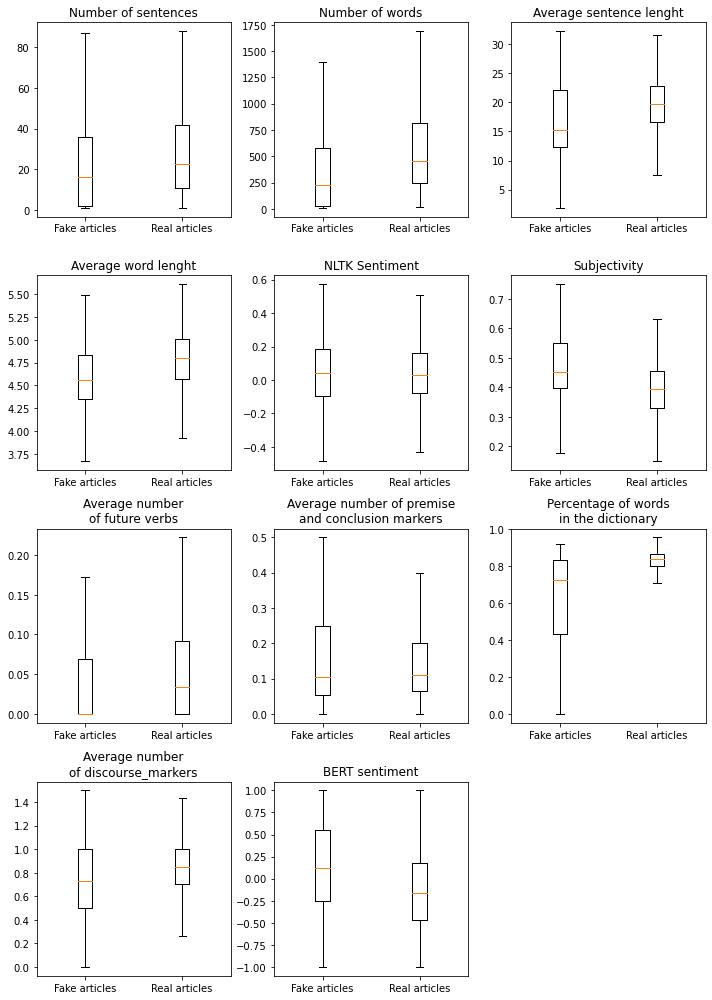

In [52]:
# Draw a boxplot for each feature comparing real and fake news' distributions of the feature

titles = ['Number of sentences', 'Number of words', 'Average sentence lenght',
       'Average word lenght', 'NLTK Sentiment', 'Subjectivity', 'Average number\nof future verbs',
       'Average number of premise\nand conclusion markers', 'Percentage of words\nin the dictionary',
       'Average number\nof discourse_markers', 'BERT sentiment']

fig, axs = plt.subplots(4, 3, figsize=(10,14))

for idx, feature in enumerate(features_df.columns):
    axs[idx//3][idx%3].boxplot(x=[data[data.Label == 0][feature], 
              data[data.Label == 1][feature]], 
              bootstrap=1000, labels=['Fake articles', 'Real articles'], showfliers=False)
    axs[idx//3][idx%3].set_title(titles[idx])

# The last plot is not used, hide it
axs[3, 2].set_visible(False)
    
fig.tight_layout()
plt.show()

In [44]:
# Create features and labels for training
features = list(features_df.columns)
labels = ['Label']

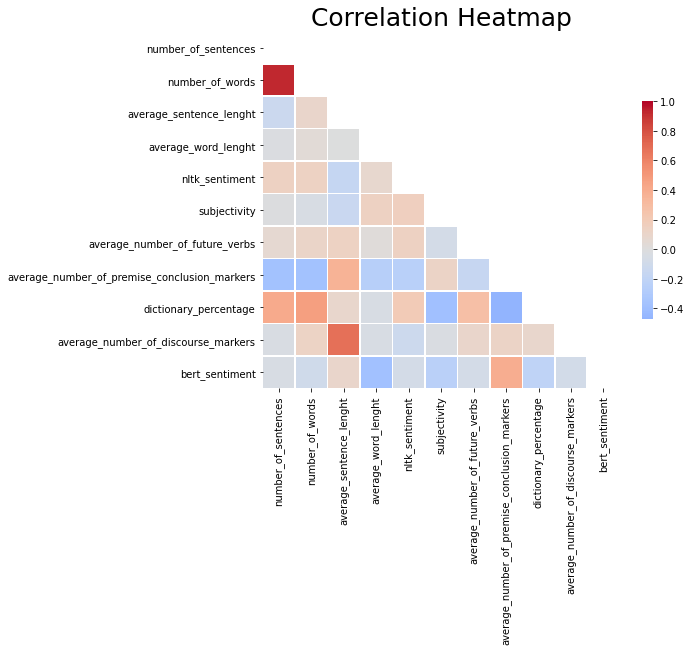

In [64]:
# Computing the Correlation Matrix
corr = data[features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 15, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("figures/corr_heatmap.jpg")

### Discussion
As we can see from the correlation heatmap, the only features that are entirely determined one by the other are not surprisingly the number of words and the number of sentences in the article. Another correlation that one may expect is the one between the average number of discourse makers and the average number of sentences in an article. Ideed, the longer the period is, the more discourse markes one needs to link the simple sentences.

Another maybe relevant correlation we can notice, is the one between percentage of words in the English dictionary and average sentence lenght. The intuitive explaination we came up with about this fact is that, on average, a real journalist, which tends in general to use more dictionary words than a fake news disseminator, wants to tell a story and so has something to talk about in details. On the other hand, every fictional particular added to a fake news may unveil its deceptive intention.

In a previous version of the notebook, this plot helped us finding out that we had a correlation between the discourse markers feature and the number of sentences/number of words. This simply happened because the old feature was obtained by computing the raw number of discourse markers in the article, which is of course stricly correlated to the number of words in the article. The more the words, the more the discourse markers. So we byepassed this "problem" by dividing the number of discourse markers in the article by the number of sentences, by eventually obtaining the average number of discourse markers per sentence.

### Step 3: Modelling

In this section we provided two modeling approaches, one logisticregression and one SVM classifier. For the logistic regression model, we use 5-fold cross validation to maintain consistency from the paper. We also included ROC curve plots for the two models.  

In [45]:
X = data[features]
y = data[labels]

# normalize dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [46]:
# Logistic Regression 
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.786 (0.014)


/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


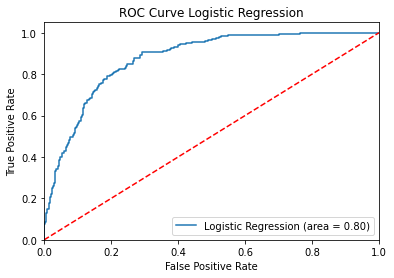

In [47]:
# Logistic Regression ROC plot

model.fit(X_train, y_train)

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend()
plt.show()

In [48]:
# Logistic Regression Model Summary

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.453658
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                 3190
Model:                          Logit   Df Residuals:                     3179
Method:                           MLE   Df Model:                           10
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                  0.3436
Time:                        18:29:12   Log-Likelihood:                -1447.2
converged:                       True   LL-Null:                       -2204.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2705      0.173      7.344      0.000       0.931       1.610
x2            -1.3220      0.

In [49]:
# SVM Classifier

#Create a svm Classifier
clf = svm.SVC(kernel='rbf', decision_function_shape = 'ovo') 
clf = make_pipeline(StandardScaler(), clf)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

/home/oraziorillo/Programs/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy: 0.8233082706766918
Precision: 0.7949367088607595
Recall: 0.839572192513369


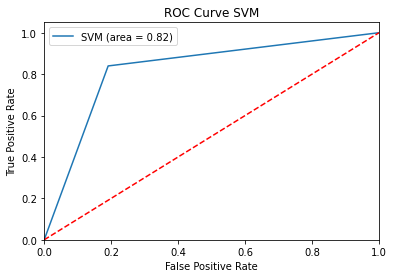

In [50]:
# SVM ROC plot

svm_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend()
plt.show()